In [1]:
import pandas as pd
import numpy as np
import datetime

In [2]:
import os
from dotenv import load_dotenv

load_dotenv("secret.env")

api_key = os.getenv("MISTRAL_AI_API_KEY")

if api_key is None:
    print("Error: MISTRAL_AI_API_KEY not found in .env file or environment variables.")
else:
    print("MISTRAL_AI_API_KEY loaded successfully.")

MISTRAL_AI_API_KEY loaded successfully.


In [4]:
import os
from mistralai import Mistral

model = "mistral-large-latest"

client = Mistral(api_key=api_key)

In [33]:
prompt = """You are a financial news analyst specializing in stock market impact. Your task is to analyze the provided news article, summarize its core content concisely, determine its sentiment (positive, negative, or neutral), and assess its importance to the specified stock.

Here is the news from stock [STOCK] title and body:
---
[TITLE]
---
[BODY]
---

Please provide your analysis in the following format:

**Sentiment:**
[Positive / Negative / Neutral]

**Summary:**
[Your concise summary of the article, typically 2-3 sentences.]

**Reasoning for Sentiment:**
[Brief explanation (1-2 sentences) of why you categorized the sentiment as such, referencing key points or tone from the article.]

**Importance to Stock [STOCK]:**
[1-5, where 1 is minimal importance and 5 is very high importance.] (Answer only in number 1-5)

**Reasoning for Importance:**
[Brief explanation (1-2 sentences) of why you assigned this importance score, referencing specific details from the article that would impact the stock.]"""

In [50]:
df = pd.read_csv("../../DataCollection/Data/News/AMZN_2025-05-26_13-36-10.csv")
display(df.head())

,ticker,publish_date,publish_time,title,body_text,url
0,AMZN,2025-05-23,14:36,Amazon.com is sued over alleged sale of contam...,By Jonathan Stempel\r\n\r\n(Reuters) - Amazon....,https://www.investing.com/news/stock-market-ne...
1,AMZN,2025-05-23,14:14,Oracle to buy $40 billion of Nvidia chips for ...,(Reuters) -Oracle will spend around $40 billio...,https://www.investing.com/news/stock-market-ne...
2,AMZN,2025-05-23,09:19,Amazon not seeing notable impact from tariffs ...,Risk Disclosure: Trading in financial instrume...,https://www.investing.com/news/pro/amazon-not-...
3,AMZN,2025-05-23,09:04,Amazon Com Inc receives Investment Bank Analys...,Risk Disclosure: Trading in financial instrume...,https://www.investing.com/news/pro/da-davidson...
4,AMZN,2025-05-23,05:53,Wall St falls as Trump tariff threats spark ma...,By Chibuike Oguh\r\n\r\nNEW YORK (Reuters) -U....,https://www.investing.com/news/stock-market-ne...


In [35]:
df["title"] = df["title"].astype(str)
df["body_text"] = df["body_text"].astype(str)
df.isnull().sum()

ticker          0
publish_date    0
publish_time    0
title           0
body_text       0
url             0
dtype: int64

In [36]:
from tqdm import tqdm
predicted = []

for index, row in tqdm(df.iterrows(), total=len(df), desc="Prompting"): 
    title = row["title"]
    body_text = row["body_text"]
    stock = row["ticker"]
    
    prompt_with_data = prompt.replace("[TITLE]", title).replace("[BODY]", body_text).replace("[STOCK]", stock)
    
    
    response = client.chat.complete(
    model= model,
    messages = [
        {
            "role": "user",
            "content": prompt_with_data,
        },
    ]
    )

    predicted.append(response.choices[0].message.content)

Prompting:   0%|          | 0/20 [00:00<?, ?it/s]

Prompting: 100%|██████████| 20/20 [01:47<00:00,  5.36s/it]


In [51]:
predicted = np.array(predicted)
df["predicted"] = predicted

In [52]:
df["sentiment"] = df["predicted"].apply(lambda x: x.split("\n")[1].strip() if len(x.split("\n")) > 1 else None)
df["importance"] = df["predicted"].apply(lambda x: x.split("\n")[10].strip() if len(x.split("\n")) > 10 else None)
df["summary"] = df["predicted"].apply(lambda x: x.split("\n")[4].strip() if len(x.split("\n")) > 4 else None)

In [53]:
df[["title", "sentiment", "importance", "summary"]].head()

,title,sentiment,importance,summary
0,Amazon.com is sued over alleged sale of contam...,Negative,4,Amazon.com is facing a lawsuit for allegedly s...
1,Oracle to buy $40 billion of Nvidia chips for ...,Neutral,3,Oracle plans to buy $40 billion worth of Nvidi...
2,Amazon not seeing notable impact from tariffs ...,Positive,4,Amazon is not experiencing a significant impac...
3,Amazon Com Inc receives Investment Bank Analys...,Neutral,1,The article is a standard risk disclosure stat...
4,Wall St falls as Trump tariff threats spark ma...,Negative,4,U.S. stocks fell on Friday following President...


In [54]:
display(df[df['sentiment']==''])
df = df[df['sentiment'] != '']

,ticker,publish_date,publish_time,title,body_text,url,predicted,sentiment,importance,summary


In [55]:
print(predicted[12])

**Sentiment:**
Positive

**Summary:**
Amazon (AMZN) shares rose 1.5% after Bill Ackman's Pershing Square revealed a new stake in the company, citing the strategic value of Amazon's dual business model and the attractive entry point due to recent price dips. Pershing Square highlighted the strength of Amazon Web Services (AWS) and the retail segment's ubiquity, expressing confidence in Amazon's future performance.

**Reasoning for Sentiment:**
The sentiment is positive because the article discusses an increase in Amazon's stock price following a significant investment from a reputable firm, Pershing Square. The firm's endorsement and positive outlook on Amazon's future performance contribute to an optimistic tone.

**Importance to Stock AMZN:**
5

**Reasoning for Importance:**
The importance is very high because the news of a major investment from a prominent firm like Pershing Square can significantly boost investor confidence and drive further interest in AMZN stock. The strategic ins

In [ ]:
df = df[df['sentiment'].isin(['Positive', 'Negative', 'Neutral'])]
df = df[df['importance'].isin(['1', '2', '3', '4', '5'])]

<Axes: title={'center': 'Sentiment Distribution'}, xlabel='sentiment'>

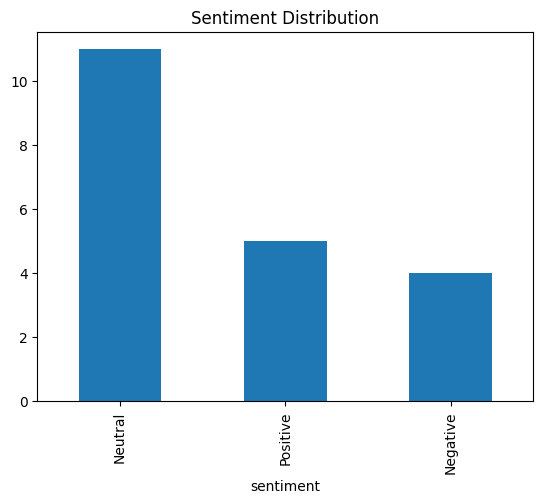

In [57]:
df['sentiment'].value_counts().plot(kind='bar', title='Sentiment Distribution')

<Axes: title={'center': 'Importance Distribution'}, xlabel='importance'>

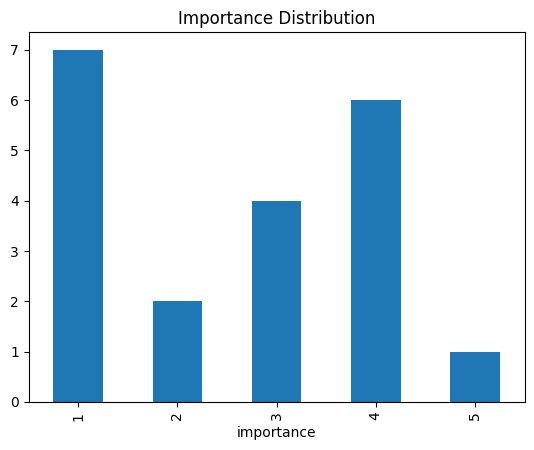

In [58]:
df['importance'].value_counts().sort_index().plot(kind='bar', title='Importance Distribution')

In [59]:
TICKER=df["ticker"][0]

In [60]:
def calculate_sentiment_score(df):
    sentiment_scores = {
        'Positive': 1,
        'Negative': -1,
        'Neutral': 0
    }
    
    df['sentiment_score'] = df['sentiment'].map(sentiment_scores)
    
    df['weighted_score'] = df['sentiment_score'] * df['importance'].astype(int)
    
    total_importance = df['importance'].astype(int).sum()
    
    if total_importance == 0:
        return 0
    
    sentiment_score = df['weighted_score'].sum() / total_importance
    return sentiment_score

In [61]:
print(f"Sentiment Score for {TICKER}: {calculate_sentiment_score(df).round(2)}")

Sentiment Score for AMZN: 0.21


In [62]:
df.drop(columns=['predicted','body_text'],inplace=True)

In [63]:
import datetime

now = datetime.datetime.now()
date_time = now.strftime("%Y-%m-%d %H-%M-%S").strip().replace(' ', '_')
df.to_csv(f"Output/Mistral_{TICKER}_{date_time}.csv", index=False)